The purpose of this document is to explore the collected wind forecast data for preliminary analysis

In [33]:
import pandas as pd
df = pd.read_csv('/Users/schristianson/Desktop/NY Wind Energy Model/historicalForecast10km2024/historicalForecast10km01.csv')

data = pd.DataFrame()

#Get all data points for the first location at 80m
columns = df.columns.tolist()

for i in range(1,13):
    df = pd.read_csv(f'/Users/schristianson/Desktop/NY Wind Energy Model/historicalForecast10km2024/historicalForecast10km{i:02}.csv')
    data = pd.concat([data, df[columns[0:3]]], axis=0)

data['Date'] = data['Date'].apply(lambda x: x if " " in x else x + " 00:00:00")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

print(data.head())

(721, 1337)
                     u80_(42.51093456200011, -76.47950663544776)  \
Date                                                               
2024-01-01 00:00:00                                     0.874212   
2024-01-01 01:00:00                                     0.098759   
2024-01-01 02:00:00                                     1.915742   
2024-01-01 03:00:00                                     1.259196   
2024-01-01 04:00:00                                     0.870409   

                     v80_(42.51093456200011, -76.47950663544776)  
Date                                                              
2024-01-01 00:00:00                                    -0.600637  
2024-01-01 01:00:00                                    -0.155481  
2024-01-01 02:00:00                                    -0.474802  
2024-01-01 03:00:00                                    -0.993299  
2024-01-01 04:00:00                                    -1.945385  


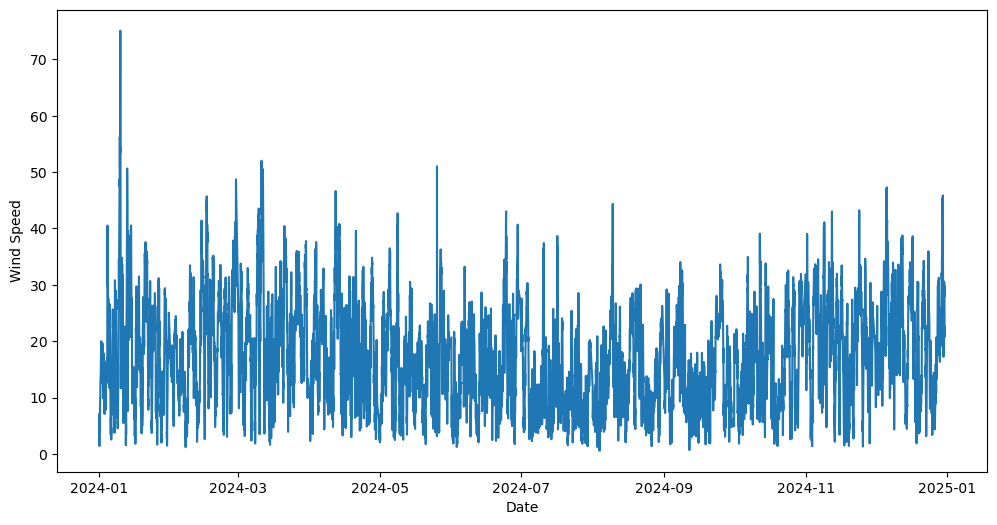

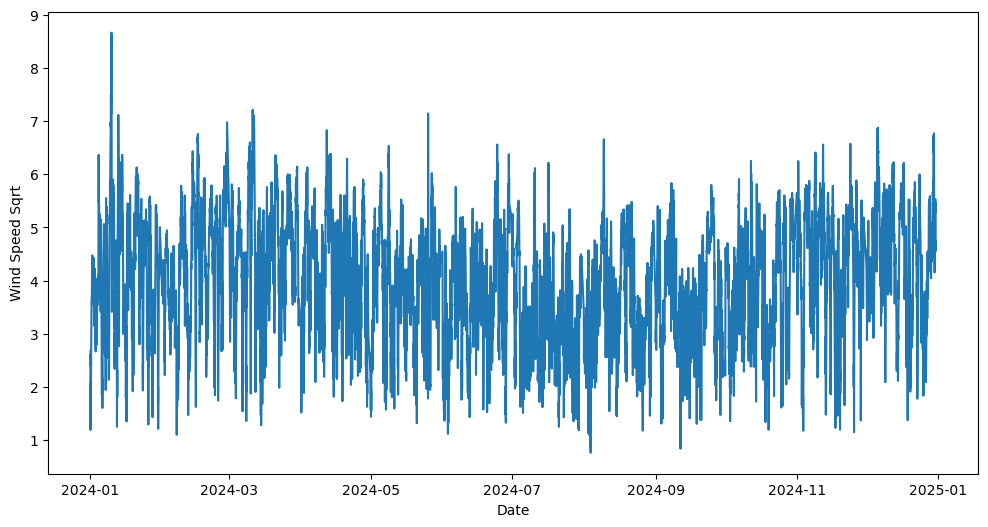

In [32]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

data['Wind Speed'] = data.apply(lambda row: np.sqrt((row**2).sum()), axis=1)
data['Wind Speed Sqrt'] = data['Wind Speed'].apply(np.sqrt)

plt.figure(figsize=(12, 6))
sns.lineplot(data, x = 'Date', y ='Wind Speed')
plt.show()

plt.figure(figsize = (12,6))
sns.lineplot(data, x='Date', y = 'Wind Speed Sqrt')
plt.show()

In [ ]:
#Get the mean of each wind speed component across the whole year for each location
import numpy as np

data = pd.DataFrame()

for i in range(1,13):
    df = pd.read_csv(f'/Users/schristianson/Desktop/NY Wind Energy Model/historicalForecast10km2024/historicalForecast10km{i:02}.csv')
    df['Date'] = df['Date'].apply(lambda x: x if " " in x else x + " 00:00:00")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    data = pd.concat([data, df[[col for col in df.columns if '80' in col]]], axis=0)

meanSpeed = np.array(data.apply(np.mean, axis=0))
df_mean = pd.DataFrame([meanSpeed], columns = data.columns)

In [4]:
#Get the mean wind speed across the whole year for each location
import numpy as np
import pandas as pd

data = pd.DataFrame()

for i in range(1,13):
    df = pd.read_csv(f'/Users/schristianson/Desktop/NY Wind Energy Model/historicalForecast10km2024/historicalForecast10km{i:02}.csv')
    df['Date'] = df['Date'].apply(lambda x: x if " " in x else x + " 00:00:00")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    data = pd.concat([data, df[[col for col in df.columns if '80' in col]]], axis=0)

data_coords = set()
for col in data.columns:
    coord = col.split("_")[1]
    data_coords.add(coord)

df_mag = pd.DataFrame(index=data.index)
new_cols = {}

data_coords = list(data_coords)
for coord in data_coords:
    matching_cols = [col for col in data.columns if str(coord) in col]
    df_selected = data[matching_cols]
    new_cols[str(coord)] = np.sqrt((df_selected ** 2).sum(axis=1))

new_df = pd.DataFrame(new_cols)
df_mag = pd.concat([df_mag, new_df], axis=1)

meanSpeedMag = np.array(df_mag.apply(np.mean, axis=0))
df_meanMag = pd.DataFrame([meanSpeedMag], columns = df_mag.columns)

mag_vals = df_mag.values
cov_matrix = np.cov(mag_vals, rowvar=False)


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(mag_vals)

kernel = RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel)
K = gp.kernel(X_scaled , X_scaled)
mu = meanSpeedMag  

In [9]:
print(type(K))

<class 'numpy.ndarray'>


In [50]:
df_mag_sqrt = np.sqrt(df_mag)
mag_vals_sqrt = df_mag_sqrt.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(mag_vals_sqrt)

# Heuristic for length scale
from scipy.spatial.distance import pdist

dists = pdist(X_scaled)  # pairwise distances
median_dist = np.median(dists)
mean_dist = np.mean(dists)

print(mean_dist)
print(median_dist)

kernel = RBF(length_scale=median_dist/2)
gp = GaussianProcessRegressor(kernel=kernel)
K = gp.kernel(X_scaled, X_scaled)

51.26804382664046
46.44632853653056


In [53]:
print(K.shape)
print(8508*8508)
print(sum(sum(K<0)))
print(K[0,:][:30])

(8508, 8508)
72386064
0
[1.         0.80128996 0.7884513  0.81932422 0.68735693 0.51389176
 0.40310909 0.31922567 0.24095949 0.21773201 0.26425653 0.31341989
 0.29467919 0.18465164 0.22060098 0.30329332 0.42352078 0.39218664
 0.34704778 0.24268665 0.24453056 0.23970017 0.1749577  0.20008863
 0.18764286 0.12450446 0.08346219 0.08013002 0.06309939 0.04926811]


In [54]:
print(df_mag.columns)

Index(['(43.88793456200016, -75.52250663544773)',
       '(43.725934562000155, -75.65450663544772)',
       '(42.375934562000104, -73.97150663544767)',
       '(42.59193456200011, -77.4035066354478)',
       '(42.969934562000134, -78.88850663544784)',
       '(42.132934562000095, -77.73350663544781)',
       '(42.78093456200011, -78.32750663544783)',
       '(42.56493456200011, -79.15250663544786)',
       '(42.0249345620001, -75.42350663544772)',
       '(42.26793456200009, -74.03750663544766)',
       ...
       '(42.753934562000126, -78.82250663544782)',
       '(42.2949345620001, -79.28450663544785)',
       '(43.07793456200014, -75.75350663544774)',
       '(42.970174342734005, -78.92123070650818)',
       '(42.375934562000104, -78.52550663544783)',
       '(43.05093456200014, -75.78650663544771)',
       '(43.725934562000155, -75.48950663544771)',
       '(44.9139345620002, -73.60850663544764)',
       '(43.88793456200016, -75.58850663544771)',
       '(42.402934562000105, -78.45

In [3]:
import os
os.chdir("..")

Number of grid squares inside NY: 17522
Number of grid squares truly inside NY: 17522


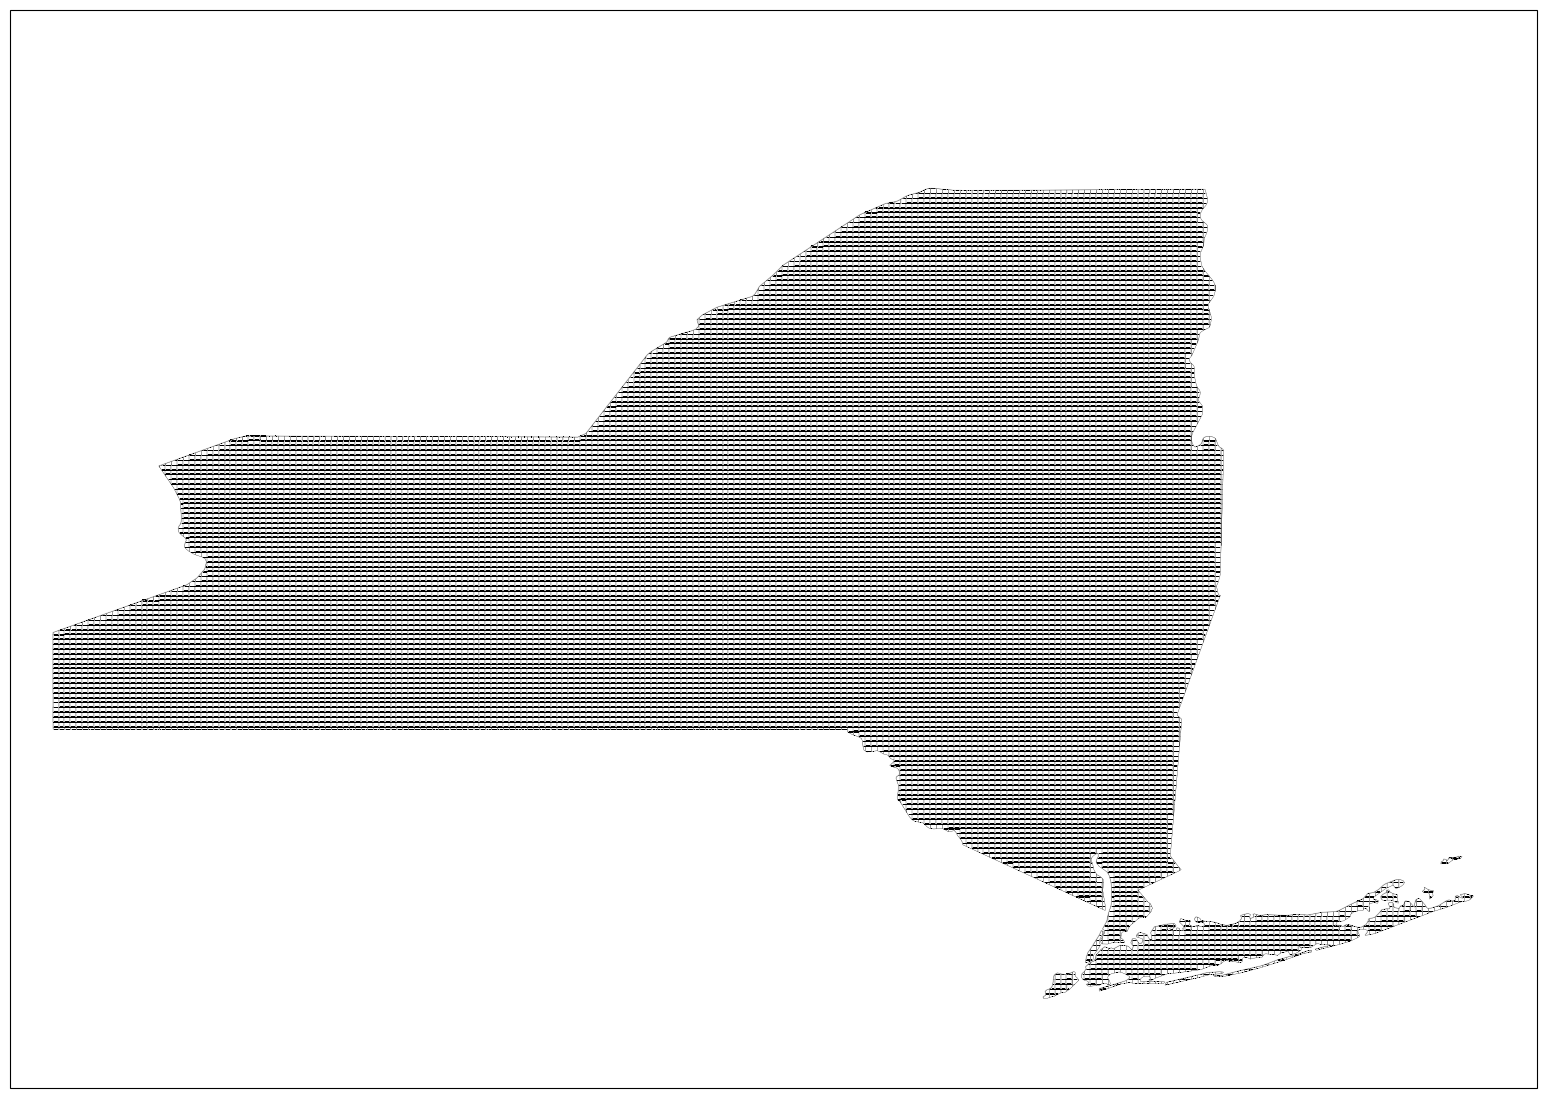

In [6]:
#Plot correlation across NY State
import geopandas as gpd
from plotting.makeNYGrid import makeNYGrid
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from shapely.geometry import box
from cartopy.io.img_tiles import Stamen
import pandas as pd

grid_gdf, centers_gdf, coords_list = makeNYGrid()

print(f"Number of grid squares inside NY: {len(grid_gdf)}")

#Get NY State Geometry
url = "data/ny_cartography_data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp"
gdf = gpd.read_file(url)

# Filter for New York
ny_state = gdf[gdf['name'] == 'New York']

ny_geometry = ny_state.geometry.iloc[0]

map_extent = [-80, -71.5, 40, 46]
map_box = box(*map_extent)  # A rectangle covering the map extent

# Subtract the shape geometry from the full extent
mask_geometry = map_box.difference(ny_geometry)

# Create a map with a PlateCarree projection
fig, ax = plt.subplots(figsize=(30, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent to the mainland U.S.
ax.set_extent(map_extent, crs=ccrs.PlateCarree())

us_feature = ShapelyFeature([ny_geometry], ccrs.PlateCarree(), facecolor='lightgray', linewidth=0.3,)
ax.add_feature(us_feature)

for geom in grid_gdf.geometry:
    geom = geom.intersection(ny_geometry)
    feature = ShapelyFeature([geom], ccrs.PlateCarree(), edgecolor="black", facecolor='white', linewidth=0.2)
    ax.add_feature(feature)


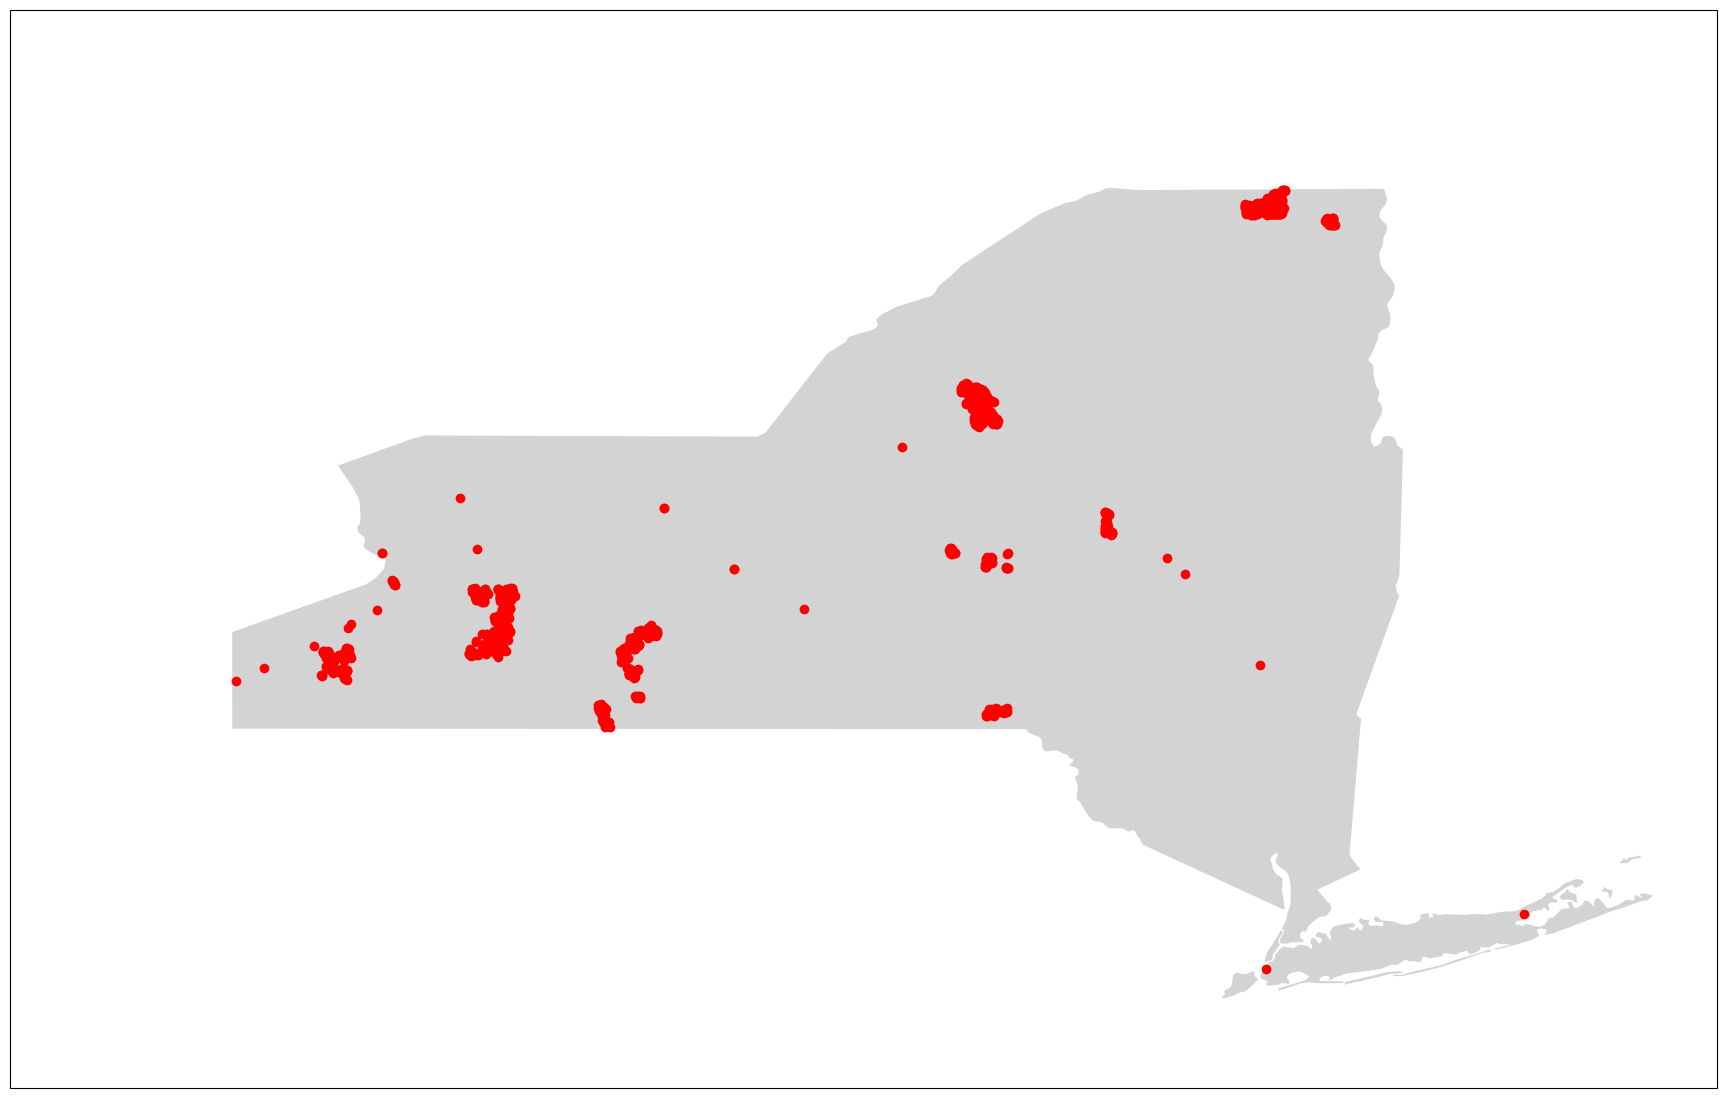

In [7]:
grid_gdf, centers_gdf, coords_list = makeNYGrid()

#Get NY State Geometry
url = "/Users/schristianson/Desktop/NY Wind Energy Model/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp"
gdf = gpd.read_file(url)

# Filter for New York
ny_state = gdf[gdf['name'] == 'New York']

ny_geometry = ny_state.geometry.iloc[0]

map_extent = [-81, -71.5, 40, 46]
map_box = box(*map_extent)  # A rectangle covering the map extent

# Subtract the shape geometry from the full extent
mask_geometry = map_box.difference(ny_geometry)

# Create a map with a PlateCarree projection
fig, ax = plt.subplots(figsize=(30, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent to the mainland U.S.
ax.set_extent(map_extent, crs=ccrs.PlateCarree())

us_feature = ShapelyFeature([ny_geometry], ccrs.PlateCarree(), facecolor='lightgray', linewidth=0.3,)
ax.add_feature(us_feature)

#load wind turbines
#df = pd.read_csv("/Users/schristianson/Desktop/NY Wind Energy Model/uswtdb_v7_2_20241120.csv")
df = pd.read_csv("/Users/schristianson/Desktop/NY Wind Energy Model/uswtdb_V8_0_20250225.csv")

# Filter for New York State (NY)
df_ny = df[df["t_state"] == "NY"]

# Select only coordinates
ny_turbine_coords = list(zip(df_ny["ylat"], df_ny["xlong"]))

for coord in ny_turbine_coords:
    lat, lon = coord
    ax.plot(lon, lat, marker='o', color='red', markersize=6, transform=ccrs.PlateCarree())

plt.show()

   Unnamed: 0            period  Megawatthours
0           0  2018-12-31T19-05          950.0
1           1  2018-12-31T20-05          940.0
2           2  2018-12-31T21-05         1074.0
3           3  2018-12-31T22-05         1149.0
4           4  2018-12-31T23-05         1214.0
Unnamed: 0         int64
period            object
Megawatthours    float64
dtype: object


KeyboardInterrupt: 

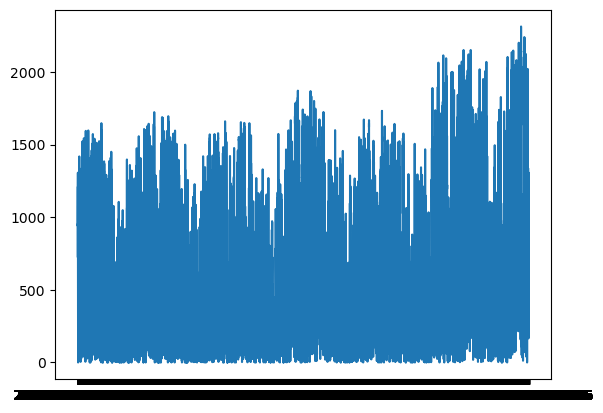

In [2]:
import seaborn as sns
import pandas as pd

df_energy = pd.read_csv('/Users/schristianson/Desktop/NY Wind Energy Model/historical_energy.csv')
print(df_energy.head())
print(df_energy.dtypes)

sns.lineplot(df_energy, y='Megawatthours')